<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_Week5_FeatureE_CrossV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO 371: Data Mining Applications

## Week 5: Feature Engineering and Model Selection
### Prof. Charles Dorner, EdD (Candidate)
### College of Computing and Informatics, Drexel University

In [47]:
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

## Collecting the data
The data we will be using is the match history data for the NBA for the 2015-2016 season.

The website [http://basketball-reference.com](http://basketball-reference.com) contains a significant number of resources
and statistics collected from the NBA and other leagues.

To download the dataset, perform the following steps:
1. Navigate to [here](http://www.basketball-reference.com/leagues/NBA_2016_games.html) in your web browser.
2. Click Share & Export.
3. Click Get table as CSV (for Excel).
4. Copy the data, including the heading, into a text file named basketball.csv.
5. Repeat this process for the other months, except do not copy the heading.

This will give you a CSV file containing the results from each game of this season of the NBA. (My file contains 1316 games and a total of 1317 lines in the file, including the header line.)

In [48]:
# Now re-run the dataset generation
from datetime import datetime, timedelta
import pandas as pd
import random

# Updated team names (NBA-style fictional)
teams = [
    "Lions", "Sharks", "Eagles", "Wolves", "Panthers",
    "Dragons", "Tigers", "Bulls", "Hawks", "Knights",
    "Kings", "Titans", "Giants", "Raiders", "Raptors",
    "Falcons", "Vikings", "Warriors", "Crusaders", "Pirates",
    "Jets", "Stallions", "Coyotes", "Spartans", "Commanders",
    "Outlaws", "Sentinels", "Gladiators", "Blazers", "Storm"
]

# Generate synthetic NBA-style data
n_games = 1316
start_date = datetime(2023, 10, 1)
dates = [start_date + timedelta(days=int(i)) for i in np.random.randint(0, 180, size=n_games)]
start_times = [f"{random.randint(1, 12)}:{random.choice(['00', '30'])} {'PM' if random.random() > 0.5 else 'AM'}" for _ in range(n_games)]
visitor_teams = np.random.choice(teams, size=n_games)
home_teams = [random.choice([team for team in teams if team != visitor_teams[i]]) for i in range(n_games)]
visitor_pts = np.random.randint(80, 130, size=n_games)
home_pts = np.random.randint(80, 130, size=n_games)
ots = np.random.choice(["", "OT", "2OT"], size=n_games, p=[0.85, 0.1, 0.05])
score_types = ["Final" if ot == "" else "OT" for ot in ots]
attends = np.random.randint(10000, 20000, size=n_games)
notes = np.random.choice(["", "Rivalry Game"], size=n_games, p=[0.95, 0.05])

# Create the DataFrame
df = pd.DataFrame({
    "Date": dates,
    "Start (ET)": start_times,
    "Visitor Team": visitor_teams,
    "VisitorPts": visitor_pts,
    "Home Team": home_teams,
    "HomePts": home_pts,
    "OT?": ots,
    "Score Type": score_types,
    "Attend.": attends,
    "Notes": notes
})

```
df = pd.read_csv('nba-2016.csv')
df.head()
```

In [49]:
df.head()

,Date,Start (ET),Visitor Team,VisitorPts,Home Team,HomePts,OT?,Score Type,Attend.,Notes
0,2023-10-29,9:00 AM,Lions,86,Storm,117,,Final,12319,
1,2023-11-08,4:00 PM,Wolves,127,Coyotes,128,,Final,17598,
2,2023-11-25,4:00 PM,Lions,113,Jets,85,OT,OT,18764,
3,2024-01-07,3:00 PM,Stallions,91,Pirates,101,OT,OT,15634,
4,2023-10-27,12:30 AM,Kings,122,Raptors,128,,Final,18341,


## Add a target column

```
df["HomeWin"] = df["VisitorPts"] < df["HomePts"]
```

In [54]:
df["HomeWin"] = df["VisitorPts"] < df["HomePts"]

## Extract the target values

```
y_homewin = df["HomeWin"].values
y_homewin
```

In [53]:
y_homewin = df["HomeWin"].values
y_homewin

array([ True,  True, False, ..., False, False, False])

## What is the home team advantage in this data set?
```
df.Homewin.mean()
```

In [55]:
df.HomeWin.mean()

np.float64(0.506838905775076)

## Predict using team names
```
df['Home Team'].nunique()
```

In [56]:
df['Home Team'].nunique()

30

Encode the team names into one-hot vectors:
```
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
onehot.fit(df[["Home Team"]])
```

In [57]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
onehot.fit(df[["Home Team"]])

OneHotEncoder()

List the unique categories corresponding to the one hot values:

```
onehot.categories_
```

In [58]:
onehot.categories_

[array(['Blazers', 'Bulls', 'Commanders', 'Coyotes', 'Crusaders',
        'Dragons', 'Eagles', 'Falcons', 'Giants', 'Gladiators', 'Hawks',
        'Jets', 'Kings', 'Knights', 'Lions', 'Outlaws', 'Panthers',
        'Pirates', 'Raiders', 'Raptors', 'Sentinels', 'Sharks', 'Spartans',
        'Stallions', 'Storm', 'Tigers', 'Titans', 'Vikings', 'Warriors',
        'Wolves'], dtype=object)]

Transform the team names into one-hot values:
```
X = onehot.transform(df[["Home Team"]]).toarray()
```

In [59]:
X = onehot.transform(df[["Home Team"]]).toarray()

Fit a decision tree on the team names:
```
from sklearn.tree import DecisionTreeClassifier
dt_nba = DecisionTreeClassifier()

dt_nba.fit(X, y_homewin)
```

In [60]:
from sklearn.tree import DecisionTreeClassifier
dt_nba = DecisionTreeClassifier()

dt_nba.fit(X, y_homewin)

DecisionTreeClassifier()

Print out the tree as text format:
```
from sklearn.tree import export_text

print(export_text(dt_nba, feature_names=onehot.categories_[0]))
```

In [61]:
from sklearn.tree import export_text

print(export_text(dt_nba, feature_names=onehot.categories_[0]))

|--- Raptors <= 0.50
|   |--- Blazers <= 0.50
|   |   |--- Commanders <= 0.50
|   |   |   |--- Storm <= 0.50
|   |   |   |   |--- Titans <= 0.50
|   |   |   |   |   |--- Giants <= 0.50
|   |   |   |   |   |   |--- Spartans <= 0.50
|   |   |   |   |   |   |   |--- Warriors <= 0.50
|   |   |   |   |   |   |   |   |--- Dragons <= 0.50
|   |   |   |   |   |   |   |   |   |--- Falcons <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- Tigers <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 19
|   |   |   |   |   |   |   |   |   |   |--- Tigers >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |   |--- Falcons >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |--- Dragons >  0.50
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |--- Warriors >  0.50
|   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |---

## Visualize the Decision Tree


```
!pip install -q dtreeviz

import dtreeviz

viz = dtreeviz.model(dt_nba,
               X,
               y_homewin,
               target_name='HomeWin',
               feature_names=onehot.categories_[0],
               class_names=["No", "Yes"]
               )

viz.view(scale=1.5)

```

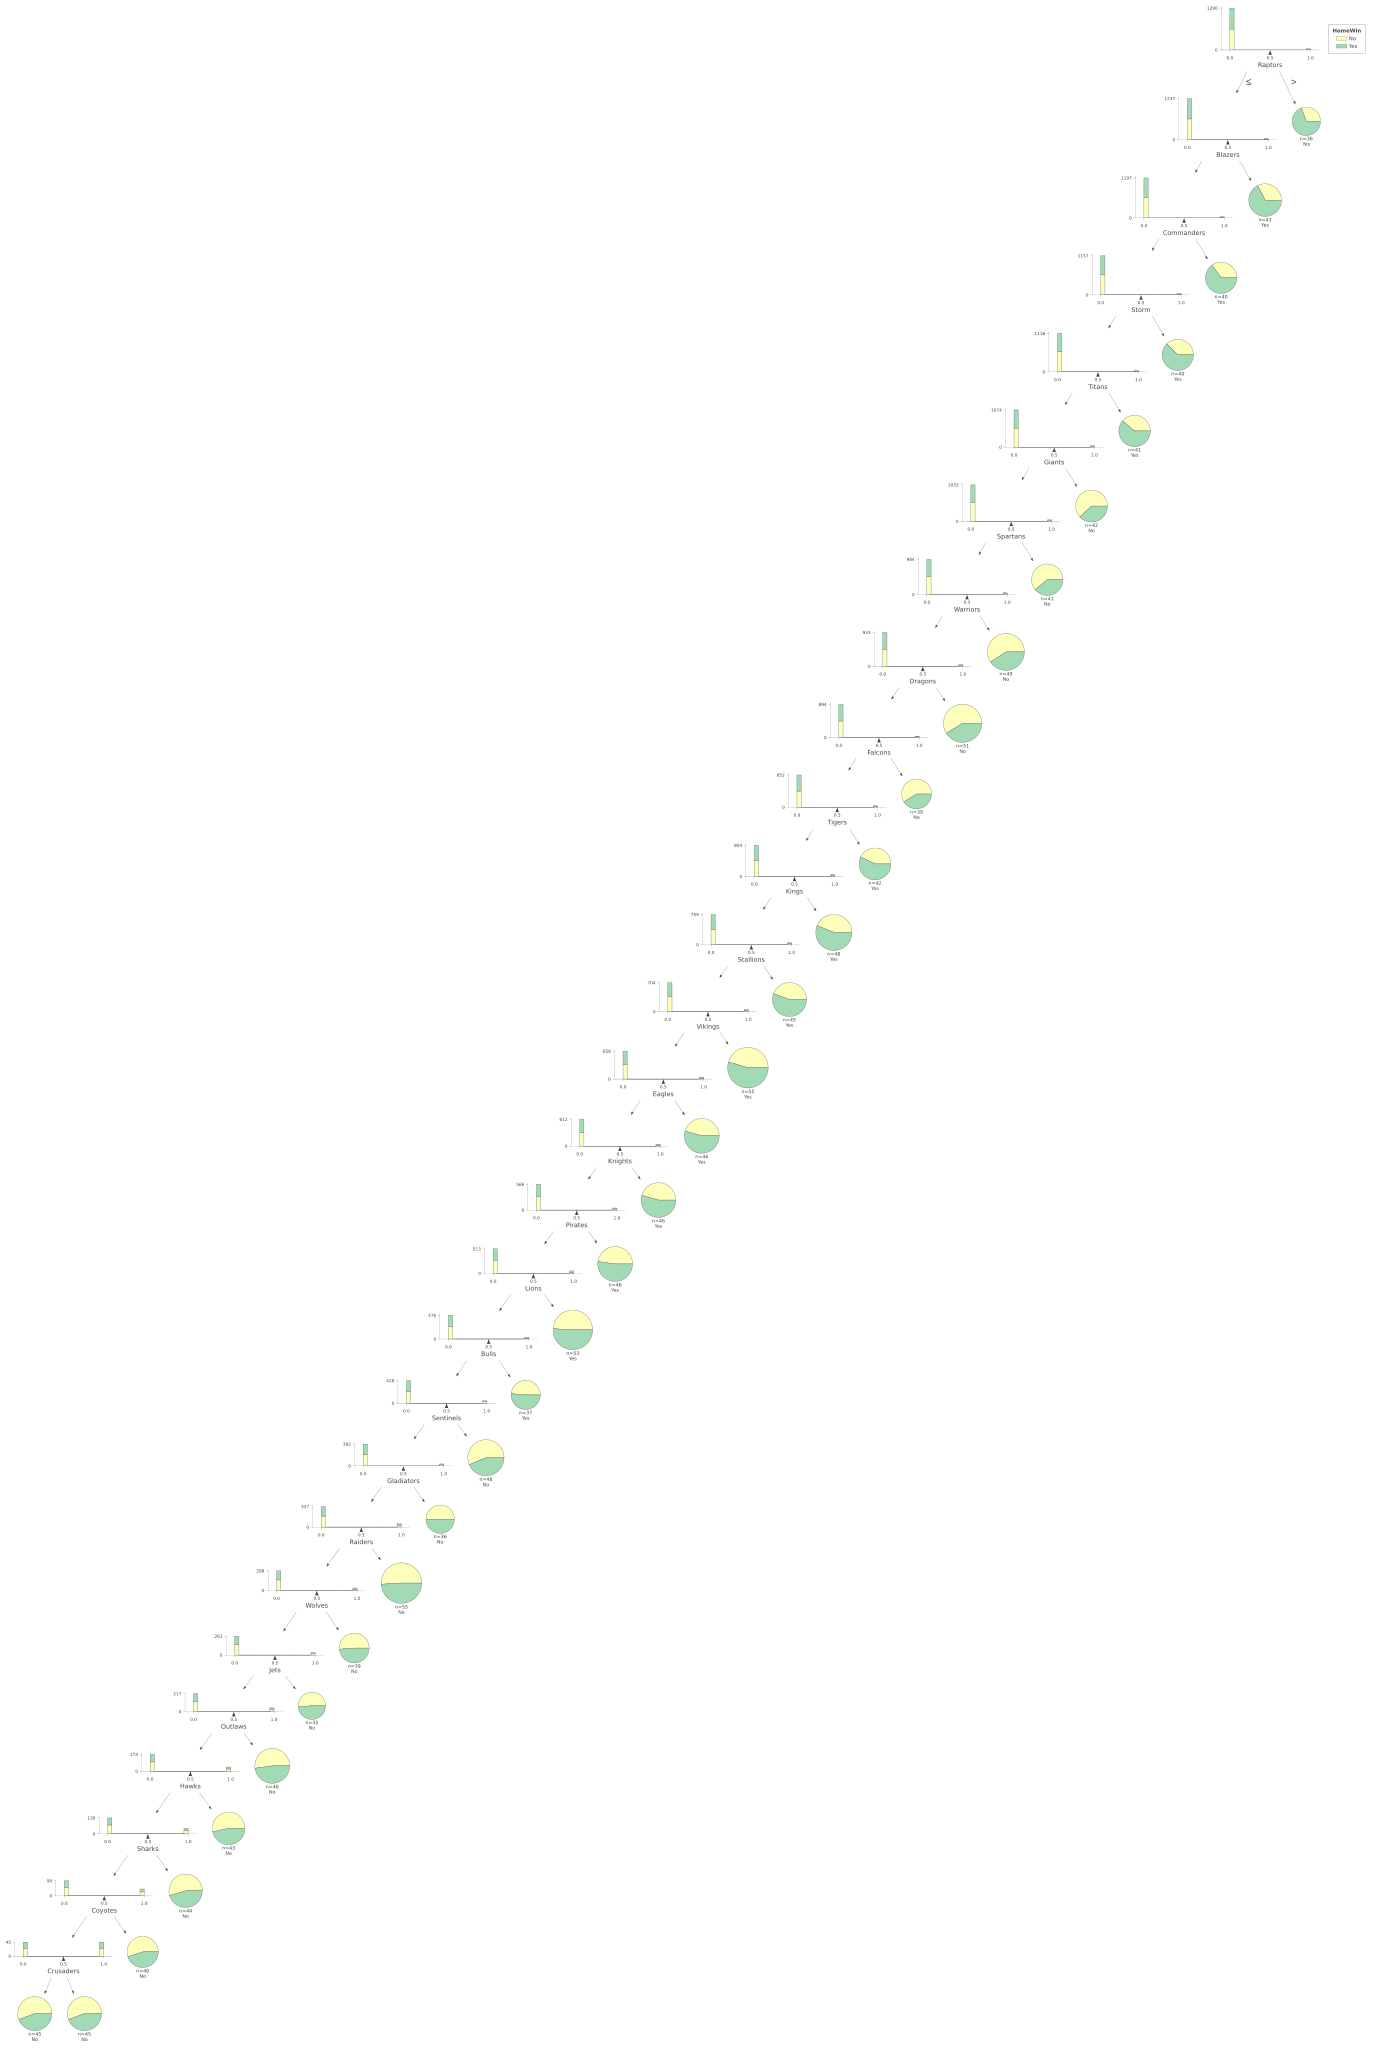

In [62]:
import dtreeviz

viz = dtreeviz.model(dt_nba,
               X,
               y_homewin,
               target_name='HomeWin',
               feature_names=onehot.categories_[0],
               class_names=["No", "Yes"]
               )

viz.view(scale=1.5)

## Evaluation
Evaluation should be done on a separate test data. Scikit Learn provides a convenient method for splitting arrays or matrices into random train and test subsets.

```
from sklearn.model_selection import train_test_split

# Split the given data set into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_homewin, test_size=0.2, random_state=42)

```

In [63]:
from sklearn.model_selection import train_test_split

# Split the given data set into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_homewin, test_size=0.2, random_state=42)

List the shapes of training and test data sets
```
X_train.shape, X_test.shape, y_train.shape, y_test.shape
```

In [64]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1052, 30), (264, 30), (1052,), (264,))

Train a decision tree on training data:
```
dt_nba = DecisionTreeClassifier()
dt_nba.fit(X_train, y_train)
```

In [65]:
dt_nba = DecisionTreeClassifier()
dt_nba.fit(X_train, y_train)

DecisionTreeClassifier()

Predict homewin labels on test data:
```
y_pred = dt_nba.predict(X_test)
```

In [66]:
y_pred = dt_nba.predict(X_test)

Evaluate the performance of the decision tree using team names:
```
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)
```

In [67]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.5075757575757576

## Cross Validation
A primary method to evaluate and select machine learning models on a limited data set. The K-Fold cross validation goes like:
- Shuffle the dataset randomly.
- Split the dataset into k groups
- For each unique group:
 - Take the group as a hold out or test data set
 - Take the remaining groups as a training data set
 - Fit a model on the training set and evaluate it on the test set
- Obtain the final score of the model using the scores on individual folds.

### Use the cross_val_score implemented in Scikit Learn

```
from sklearn.model_selection import cross_val_score

dt_nba = DecisionTreeClassifier()

scores= cross_val_score(dt_nba, X, y_homewin, cv=10, scoring='accuracy')

```

In [68]:
from sklearn.model_selection import cross_val_score

dt_nba = DecisionTreeClassifier()

scores= cross_val_score(dt_nba, X, y_homewin, cv=10, scoring='accuracy')

Print out the mean accuracy:
```
print("The accuracy of predicting on names: {}".format(np.mean(scores)))
```

In [69]:
print("The accuracy of predicting on names: {}".format(np.mean(scores)))

The accuracy of predicting on names: 0.507529493407356


Compare to the home team advantage:
```
df["HomeWin"].mean()
```

In [70]:
df["HomeWin"].mean()

np.float64(0.506838905775076)

## Create a new feature: who won the last game

Initialize two new columns with False (0) values:
```
df['HomeWonLast'] = 0 # did the home team win its last game?
df['VisitorWonLast'] = 0 # did the visitor team win its last game?
```

In [71]:
df['HomeWonLast'] = 0 # did the home team win its last game?
df['VisitorWonLast'] = 0 # did the visitor team win its last game?

Use a dictionary to compute the correct values:

```
from collections import defaultdict
won_last = defaultdict(int)
```

In [72]:
from collections import defaultdict
won_last = defaultdict(int)

An algorithm for computing the value whether the home team won last game:
```
for index, row in df.sort_values("Date").iterrows():
    home_team = row['Home Team']
    visitor_team = row['Visitor Team']
    df.at[index, 'HomeWonLast'] = won_last[home_team]
    df.at[index, 'VisitorWonLast'] = won_last[visitor_team]
    won_last[home_team] = int(row['HomeWin'])
    won_last[visitor_team] = 1- int(row['HomeWin'])
```

In [73]:
for index, row in df.sort_values("Date").iterrows():
    home_team = row['Home Team']
    visitor_team = row['Visitor Team']
    df.at[index, 'HomeWonLast'] = won_last[home_team]
    df.at[index, 'VisitorWonLast'] = won_last[visitor_team]
    won_last[home_team] = int(row['HomeWin'])
    won_last[visitor_team] = 1- int(row['HomeWin'])

### Predict using HomeWonLast and VisitorWonLast

```
X_lastWon = df[['HomeWonLast', 'VisitorWonLast']]

dt_nba = DecisionTreeClassifier()

scores = cross_val_score(dt_nba, X_lastWon, y_homewin, scoring='accuracy')

print("The accuracy of predicting on who won last: {}".format(np.mean(scores)))

```

In [74]:
X_lastWon = df[['HomeWonLast', 'VisitorWonLast']]

dt_nba = DecisionTreeClassifier()

scores = cross_val_score(dt_nba, X_lastWon, y_homewin, scoring='accuracy')

print("The accuracy of predicting on who won last: {}".format(np.mean(scores)))

The accuracy of predicting on who won last: 0.48024253946307177


### Predict using names and previous won

```
name_oneHot = pd.get_dummies(df['Home Team'])

X_nameOneHot_lastWon = pd.concat([name_oneHot, df[['HomeWonLast', 'VisitorWonLast']]], axis=1)
X_nameOneHot_lastWon

```

In [75]:
name_oneHot = pd.get_dummies(df['Home Team'])

X_nameOneHot_lastWon = pd.concat([name_oneHot, df[['HomeWonLast', 'VisitorWonLast']]], axis=1)
X_nameOneHot_lastWon

,Blazers,Bulls,Commanders,Coyotes,Crusaders,Dragons,Eagles,Falcons,Giants,Gladiators,...,Spartans,Stallions,Storm,Tigers,Titans,Vikings,Warriors,Wolves,HomeWonLast,VisitorWonLast
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,1,1
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1,1
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1,1
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1,1
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1,0
1312,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,0,1
1313,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,0,0
1314,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,0,0


Fit the evaluate the decision tree:
```
dt_nba = DecisionTreeClassifier()
scores = cross_val_score(dt_nba, X_nameOneHot_lastWon, y_homewin, scoring='accuracy')
print('The accuracy of predicting on names and last won: {}'.format(np.mean(scores)))
```

In [83]:
dt_nba = DecisionTreeClassifier()
scores = cross_val_score(dt_nba, X_nameOneHot_lastWon, y_homewin, scoring='accuracy')
print('The accuracy of predicting on names and last won: {}'.format(np.mean(scores)))

The accuracy of predicting on names and last won: 0.48783269961977177


## Random Forest
An ensemble method consisting of a large number of individual decision trees.

It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees.

```
from sklearn.ensemble import RandomForestClassifier


randomForest = RandomForestClassifier(random_state=14)
scores = cross_val_score(randomForest, X_nameOneHot_lastWon, y_homewin, scoring='accuracy')
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

```

In [77]:
from sklearn.ensemble import RandomForestClassifier


randomForest = RandomForestClassifier(random_state=14)
scores = cross_val_score(randomForest, X_nameOneHot_lastWon, y_homewin, scoring='accuracy')
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

Accuracy: 48.9%


## Grid search for model selection
- A tuning technique that attempts to compute the optimum values of hyperparameters.
- An exhaustive search that is performed on a the specific parameter values of a model.

```
from sklearn.model_selection import GridSearchCV

```

In [78]:
from sklearn.model_selection import GridSearchCV

Define the grid of parameters for tuning:
```
parameter_space = {
"max_features": ["sqrt", "log2", None],
"n_estimators": [100, 200],
"criterion": ["gini", "entropy"],
"min_samples_leaf": [2, 4, 6],
}

```

In [79]:
parameter_space = {
"max_features": ["sqrt", "log2", None],
"n_estimators": [100, 200],
"criterion": ["gini", "entropy"],
"min_samples_leaf": [2, 4, 6],
}

Create a Random Forest and tune its parameters:
```
clf = RandomForestClassifier(random_state=14)

grid = GridSearchCV(clf, parameter_space)

grid.fit(X_nameOneHot_lastWon, y_homewin)
print("Accuracy: {0:.1f}%".format(grid.best_score_ * 100))
```

In [80]:
clf = RandomForestClassifier(random_state=14)

grid = GridSearchCV(clf, parameter_space)

grid.fit(X_nameOneHot_lastWon, y_homewin)
print("Accuracy: {0:.1f}%".format(grid.best_score_ * 100))

Accuracy: 50.6%


Print out the best model:
```
print(grid.best_estimator_)
```

In [81]:
print(grid.best_estimator_)

RandomForestClassifier(min_samples_leaf=6, random_state=14)


## Predict Using the Final Model

```
final_model =  grid.best_estimator_

y_pred = final_model.predict(X_nameOneHot_lastWon)

accuracy_score(y_homewin, y_pred)

```

In [82]:
final_model =  grid.best_estimator_

y_pred = final_model.predict(X_nameOneHot_lastWon)

accuracy_score(y_homewin, y_pred)

0.6056231003039514

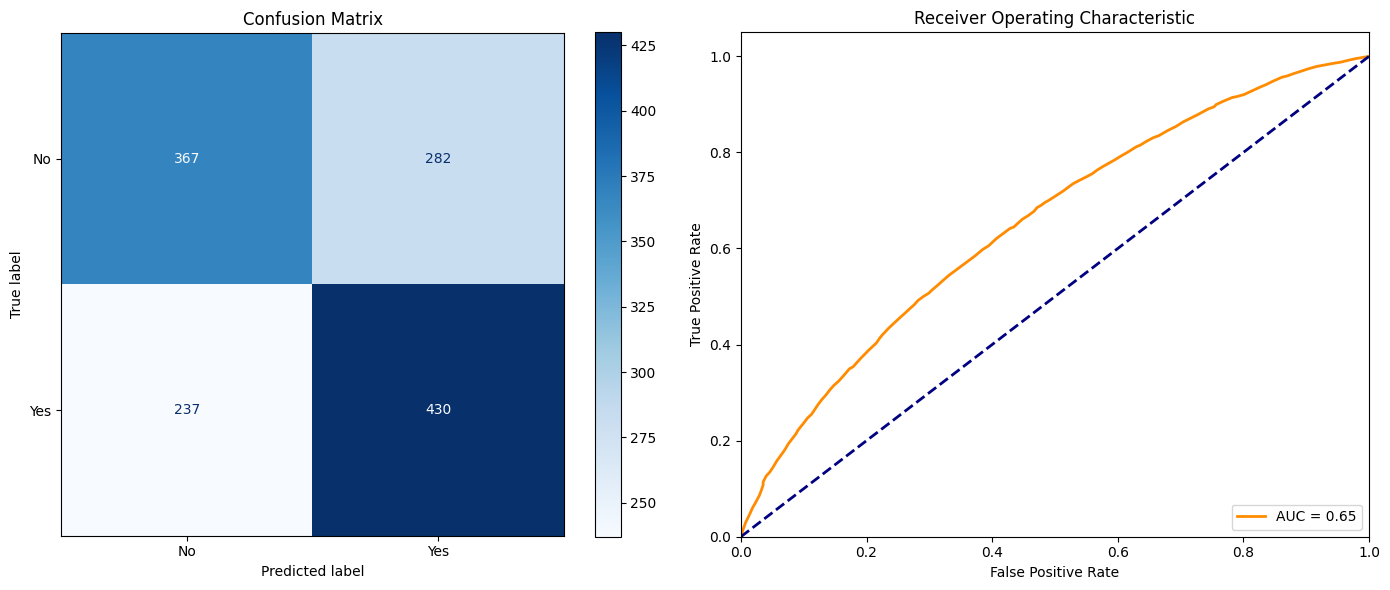

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Confusion matrix for final model
cm = confusion_matrix(y_homewin, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])

# ROC curve
fpr, tpr, _ = roc_curve(y_homewin, final_model.predict_proba(X_nameOneHot_lastWon)[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Confusion matrix
axs[0].set_title("Confusion Matrix")
disp.plot(ax=axs[0], cmap="Blues")

# ROC Curve
axs[1].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('Receiver Operating Characteristic')
axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


In [85]:
# Calculate all metrics based on the confusion matrix values
TP = 430
TN = 367
FP = 282
FN = 237

# Total predictions
total = TP + TN + FP + FN

# Metrics
accuracy = (TP + TN) / total
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1_score = 2 * (precision * recall) / (precision + recall)
auc_score = 0.65  # AUC provided from ROC curve

# Print all calculated metrics
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print()
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall (Sensitivity): {recall:.4f} ({recall*100:.2f}%)")
print(f"Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
print(f"F1 Score: {f1_score:.4f} ({f1_score*100:.2f}%)")
print(f"AUC (Area Under Curve): {auc_score:.4f} ({auc_score*100:.2f}%)")

True Positives (TP): 430
True Negatives (TN): 367
False Positives (FP): 282
False Negatives (FN): 237

Accuracy: 0.6056 (60.56%)
Precision: 0.6039 (60.39%)
Recall (Sensitivity): 0.6447 (64.47%)
Specificity: 0.5655 (56.55%)
F1 Score: 0.6236 (62.36%)
AUC (Area Under Curve): 0.6500 (65.00%)
